### Preamble
- This notebook is illustrates gradient-based minimization of sample paths

In [1]:
import numpy as np
import tensorflow as tf

from tqdm import tqdm
from itertools import count
from gpflow.kernels import Matern52
from gpflow.config import default_float as floatx
from gpflow_sampling.models import PathwiseGPR

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', family='serif', size=12)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'''
       \usepackage{amsmath,amsfonts}
       \renewcommand{\v}[1]{\boldsymbol{#1}}''')
plt.rc('figure', dpi=256)

In [3]:
tf.random.set_seed(1)

### Generate toy data

In [4]:
kernel = Matern52(lengthscales=0.1)
noise2 = 1e-3  # measurement noise variance

xmin = 0.15  # range over which we observe
xmax = 0.50  # the behavior of a function $f$
X = tf.convert_to_tensor(np.linspace(xmin, xmax, 4)[:, None])

K = kernel(X, full_cov=True)
L = tf.linalg.cholesky(tf.linalg.set_diag(K, tf.linalg.diag_part(K) + noise2))
y = L @ tf.random.normal([len(X), 1], dtype=floatx())
y -= tf.reduce_mean(y)  # for simplicity, center the data

### Create model and draw sample paths

In [5]:
model = PathwiseGPR(data=(X, y), kernel=kernel, noise_variance=noise2)
paths = model.generate_paths(num_samples=4, num_bases=1024)
_ = model.set_paths(paths)  # use a persistent set of sample paths

### Gradient-based minimization
- For each path, run gradient descent starting from 32 random locations

In [6]:
Xinit = tf.random.uniform(paths.sample_shape + [32, 1], dtype=floatx())
Xvars = tf.Variable(Xinit, constraint=lambda x: tf.clip_by_value(x, 0, 1))

@tf.function
def closure(sample_axis=0):
    """
    Passing sample_axis=0 indicates that the 0-th axis of Xnew 
    should be evaluated 1-to-1 with the individuals paths.
    """
    return model.predict_f_samples(Xnew=Xvars, sample_axis=sample_axis)

optimizer = tf.keras.optimizers.Adam()
for step in tqdm(range(1000)):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(Xvars)
        fvals = closure()

    grads = tape.gradient(fvals, Xvars)
    optimizer.apply_gradients([(grads, Xvars)])

100%|██████████| 1000/1000 [00:05<00:00, 170.25it/s]


### Visualize

In [7]:
def take_along_axis(arr: tf.Tensor, indices: tf.Tensor, axis: int) -> tf.Tensor:
    """
    Tensorflow equivalent of <numpy.take_along_axis>
    """
    _arr = tf.convert_to_tensor(arr)
    _idx = tf.convert_to_tensor(indices)
    _axis = arr.shape.ndims + axis if (axis < 0) else axis

    components = []
    for i, (size_a, size_i) in enumerate(zip(_arr.shape, _idx.shape)):
        if i == _axis:
            components.append(tf.range(size_i, dtype=_idx.dtype))
        elif size_a == 1:
            components.append(tf.zeros(size_i, dtype=_idx.dtype))
        else:
            assert size_i in (1, size_a), \
                ValueError(f'Shape mismatch: {_arr.shape} vs {_idx.shape}')
            components.append(tf.range(size_a, dtype=_idx.dtype))

    mesh = tf.meshgrid(*components, indexing='ij')
    mesh[_axis] = tf.broadcast_to(_idx, mesh[0].shape)
    indices_nd = tf.stack(mesh, axis=-1)
    return tf.gather_nd(arr, indices_nd)

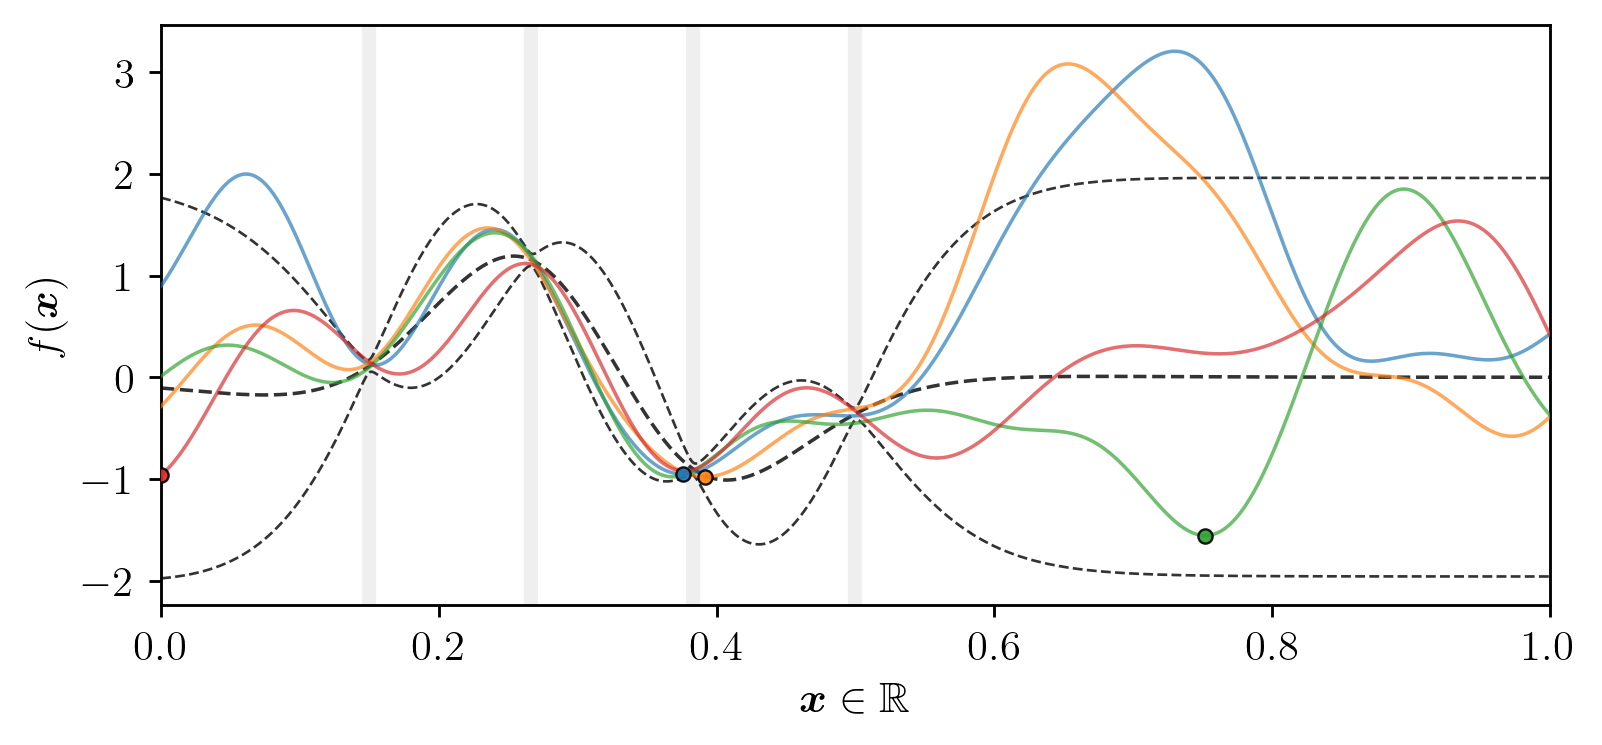

In [8]:
fig, ax = plt.subplots(figsize=(7, 3))
lower = tf.cast(0.025, floatx())
upper = tf.cast(0.975, floatx())

# Indicate where the training data is located
for x in X:  
    ax.axvline(x, 
               linewidth=4,
               zorder=0,
               alpha=0.25,
               color='silver')

Xnew = np.linspace(0, 1, 1024)[:, None]
fnew = tf.squeeze(model.predict_f_samples(Xnew))
mu, sigma2 = map(tf.squeeze, model.predict_f(Xnew))

# Show gold-standard quantiles
ax.plot(Xnew, mu , '--k', linewidth=1.0, alpha=0.8)
ax.plot(Xnew, mu + tf.math.ndtri(lower) * tf.sqrt(sigma2), '--k', linewidth=0.75, alpha=0.8)
ax.plot(Xnew, mu + tf.math.ndtri(upper) * tf.sqrt(sigma2), '--k', linewidth=0.75, alpha=0.8)

# Plot samples paths and pathwise minimizers
fcand = model.predict_f_samples(Xvars, sample_axis=0)
index = tf.argmin(fcand, axis=1)
xmins = take_along_axis(Xvars, index[..., None], axis=1)
fmins = take_along_axis(fcand, index[..., None], axis=1)
cmap = plt.get_cmap('tab10')
colors = cmap(range(model.paths.sample_shape[0]))
for i, xmin, fmin, f in zip (count(), xmins, fmins, fnew):
    ax.plot(Xnew, f, zorder=99, color=colors[i], alpha=2/3, linewidth=1.0)
    ax.scatter(xmin, fmin, zorder=999, color=colors[i], alpha=0.9, linewidth=2/3,
               marker='o', s=16, edgecolor='k')

_ = ax.set_ylabel(r'$f(\v{x})$')
_ = ax.set_xlim(0, 1)
_ = ax.set_xlabel(r'$\v{x} \in \mathbb{R}$')